# MLlib 機械学習

In [35]:
#SVM logit  sample code .  if you know more info , please see url.
#http://qiita.com/kenmatsu4/items/00ad151e857d546a97c3

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
plt.style.use('ggplot')

# http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
iris = datasets.load_iris()


## scikit-learnのirisデータを取得。

In [32]:
# ------- Create Color Map ------- #
xmin = 4.0
xmax = 8.5
ymin = 0
ymax = 8
n = 100
xx = np.linspace(xmin, xmax, n)
yy = np.linspace(ymin, ymax, n)
X, Y = np.meshgrid(xx, yy)

# 2015.9.15 追加：predictの分散処理化
f_XY = np.column_stack([X.flatten(), Y.flatten()])
sc_XY = sc.parallelize(f_XY)
res = sc_XY.map(lambda data: model.predict(data))  # 学習したデータから、各点がどちらに分類されるか予測実行
Z = np.array(res.collect()).reshape(X.shape)


# MLlib(SVM)でClassification

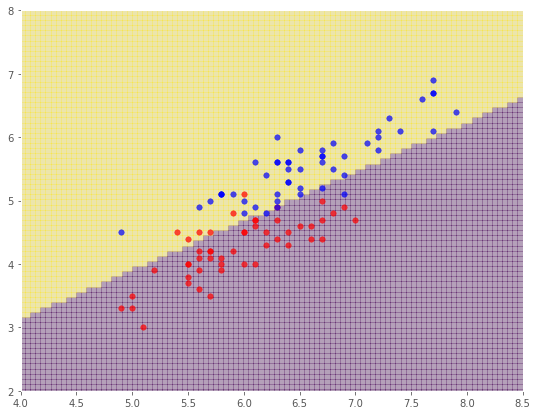

In [33]:
from pyspark.mllib.classification import SVMWithSGD
from pyspark.mllib.regression import LabeledPoint

# SVMは2値分類なので、2種類に絞る
idx = np.r_[ np.where(iris.target == 1)[0],  np.where(iris.target == 2)[0]]

# Sparkが読み取れるようにデータを変換
dat = np.column_stack([iris.target[idx]-1, iris.data[idx,0],iris.data[idx,2]])
data = sc.parallelize(dat)
def parsePoint(vec):
    return LabeledPoint(vec[0], vec[1:])
parsedData = data.map(parsePoint)

# SVMで学習実行
model = SVMWithSGD.train(parsedData, iterations=5000)

# ------- Predict Data ------- #
# 2015.9.15 追加：predictの分散処理化
f_XY = np.column_stack([X.flatten(), Y.flatten()])
sc_XY = sc.parallelize(f_XY)
res = sc_XY.map(lambda data: model.predict(data))  # 学習したデータから、各点がどちらに分類されるか予測実行
Z = np.array(res.collect()).reshape(X.shape)

# 2015.9.15 削除
#Z = np.zeros_like(X)
#for i in range(n):
#    for j in range(n):
#        Z[i,j] = model.predict([xx[j],yy[i]])


# ---------- Draw Graph ---------- # 
plt.figure(figsize=(9,7))
xmin = 4.0
xmax = 8.5
ymin = 2
ymax = 8
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# 点をプロット
for i, color in enumerate('rb'):
    idx = np.where(iris.target == i+1)[0]
    plt.scatter(iris.data[idx,0],iris.data[idx,2], c=color, s=30, alpha=.7, zorder=100)

# 塗りつぶし描画
plt.pcolor(X, Y, Z, alpha=0.3)

# MLlib(ロジスティック回帰)でClassification

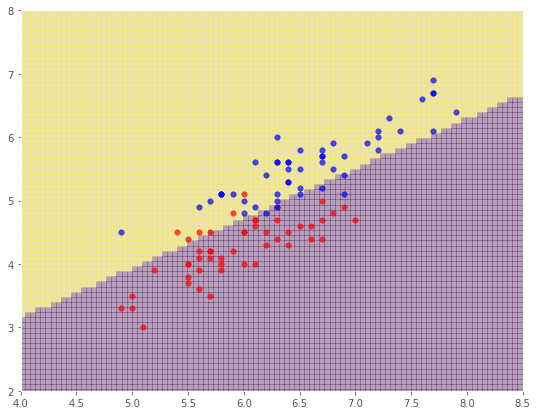

In [37]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# ロジスティック回帰で学習実行
model = LogisticRegressionWithLBFGS.train(parsedData)

# ------- Predict Data ------- #
# 2015.9.15 追加：predictの分散処理化
f_XY = np.column_stack([X.flatten(), Y.flatten()])
sc_XY = sc.parallelize(f_XY)
res = sc_XY.map(lambda data: model.predict(data))  # 学習したデータから、各点がどちらに分類されるか予測実行
Z = np.array(res.collect()).reshape(X.shape)

# 2015.9.15 削除
#Z = np.zeros_like(X)
#for i in range(n):
#    for j in range(n):
#        Z[i,j] = model.predict([xx[j],yy[i]])

# ---------- Draw Graph ---------- # 
plt.figure(figsize=(9,7))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# 点をプロット
for i, color in enumerate('rb'):
    idx = np.where(iris.target == i+1)[0]
    plt.scatter(iris.data[idx,0],iris.data[idx,2], c=color, s=30, alpha=.7, zorder=100)

# 塗りつぶし描画
plt.pcolor(X, Y, Z, alpha=0.3)

# MLlib(ランダムフォレスト)でClassification

In [38]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

# Sparkが読み取れるようにデータを変換
dat = np.column_stack([iris.target[:], iris.data[:,0],iris.data[:,2]])
data = sc.parallelize(dat)
parsedData = data.map(parsePoint)

# 訓練データとテストデータに分割
(trainingData, testData) = parsedData.randomSplit([0.7, 0.3])


# ランダムフォレストで学習実行
model = RandomForest.trainClassifier(trainingData, numClasses=3,
                                     categoricalFeaturesInfo={},
                                     numTrees=5, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

# Evaluate model on test instances and compute test error
predictions = model.predict(testData.map(lambda x: x.features))
labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testData.count())
print('Test Error = ' + str(testErr))
print('Learned classification forest model:')
print(model.toDebugString())

Test Error = 0.0196078431373
Learned classification forest model:
TreeEnsembleModel classifier with 5 trees

  Tree 0:
    If (feature 1 <= 1.9)
     Predict: 0.0
    Else (feature 1 > 1.9)
     If (feature 1 <= 4.9)
      If (feature 1 <= 4.7)
       Predict: 1.0
      Else (feature 1 > 4.7)
       If (feature 0 <= 6.2)
        Predict: 2.0
       Else (feature 0 > 6.2)
        Predict: 1.0
     Else (feature 1 > 4.9)
      If (feature 1 <= 5.0)
       If (feature 0 <= 5.7)
        Predict: 2.0
       Else (feature 0 > 5.7)
        Predict: 1.0
      Else (feature 1 > 5.0)
       If (feature 0 <= 6.0)
        Predict: 2.0
       Else (feature 0 > 6.0)
        Predict: 2.0
  Tree 1:
    If (feature 1 <= 1.9)
     Predict: 0.0
    Else (feature 1 > 1.9)
     If (feature 1 <= 4.8)
      If (feature 0 <= 4.9)
       If (feature 1 <= 3.3)
        Predict: 1.0
       Else (feature 1 > 3.3)
        Predict: 2.0
      Else (feature 0 > 4.9)
       If (feature 1 <= 4.7)
        Predict: 1.0
  

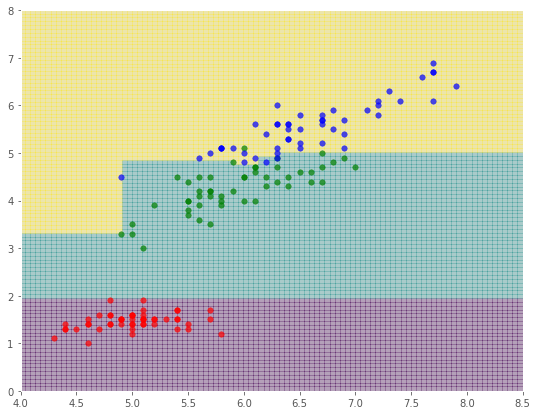

In [39]:
# ------- Predict Data ------- #
Z = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        Z[i,j] = model.predict([xx[j],yy[i]])

# ---------- Draw Graph ---------- # 
plt.figure(figsize=(9,7))
xmin = 4.0
xmax = 8.5
ymin = 0
ymax = 8
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# 点をプロット
for i, color in enumerate('rgb'):
    idx = np.where(iris.target == i)[0]
    plt.scatter(iris.data[idx,0],iris.data[idx,2], c=color, s=30, alpha=.7, zorder=100)

# 塗りつぶし描画
plt.pcolor(X, Y, Z, alpha=0.3)